In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplfinance as mpf

In [2]:
def load_trades_from_csv(path):
    trades = pd.read_csv(path,
                         sep=';',
                         header=None,
                         names=['datetime','id','price','volume','origin_side'])#[['date','time','price','volume','origin_side']]
    trades['datetime'] = pd.to_datetime(trades['datetime'],format='%Y:%m:%d %H:%M:%S.%f')
    # display(trades.head(1))
    # display(trades['time'].str + trades['date'].str)
    # trades['datetime'] = pd.to_datetime(trades['time'])
    # display(trades.head(1))
    # trades = trades.drop(columns=['date','time'])[['datetime','id','price','volume','origin_side']]
    return trades

path = 'data/trades_RIU2@FORTS_2022_08_19_2022_08_19.csv'
trades = load_trades_from_csv(path)
display(trades)
trades.info()
display('Duplicates count',trades.duplicated().sum())

,datetime,id,price,volume,origin_side
0,2022-08-19 10:00:00.441,1925035759752974906,111670.0,1,Sell
1,2022-08-19 10:00:00.557,1925035759752974907,111670.0,1,Sell
2,2022-08-19 10:00:00.558,1925035759752974908,111670.0,1,Sell
3,2022-08-19 10:00:00.558,1925035759752974909,111670.0,1,Sell
4,2022-08-19 10:00:00.558,1925035759752974910,111660.0,1,Sell
...,...,...,...,...,...
85429,2022-08-19 23:49:56.138,1925035764047941368,112590.0,1,Buy
85430,2022-08-19 23:49:56.153,1925035764047941369,112600.0,1,Buy
85431,2022-08-19 23:49:57.328,1925035764047941371,112590.0,1,Buy
85432,2022-08-19 23:49:57.328,1925035764047941372,112590.0,2,Buy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85434 entries, 0 to 85433
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     85434 non-null  datetime64[ns]
 1   id           85434 non-null  int64         
 2   price        85434 non-null  float64       
 3   volume       85434 non-null  int64         
 4   origin_side  85434 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.3+ MB


'Duplicates count'

0

Let's plot ticks. 

In [3]:
trades = trades.set_index('datetime')

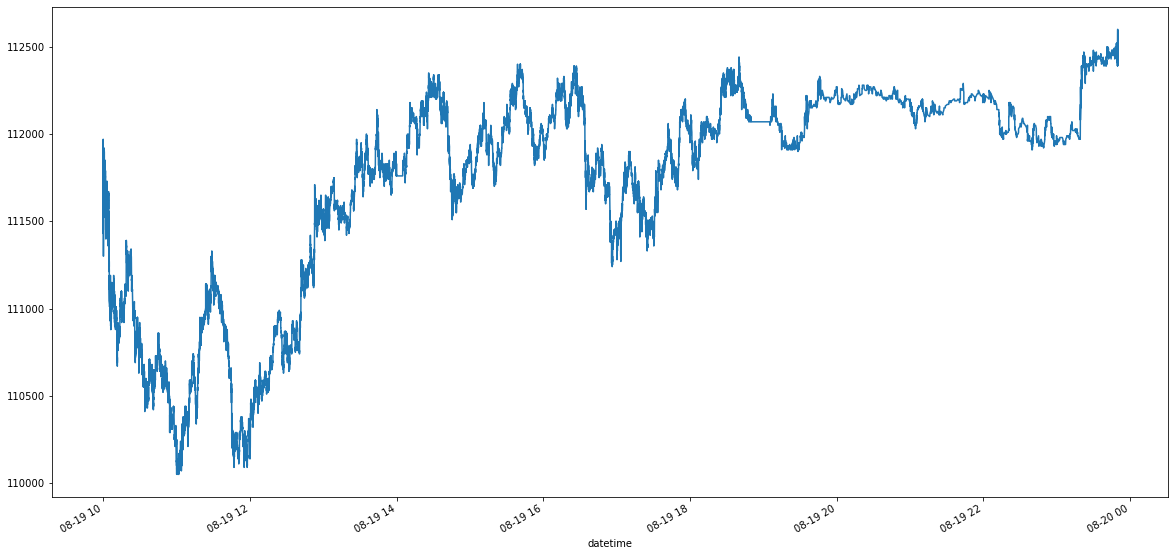

In [4]:
trades['price'].plot(figsize=(20,10))
plt.show()

Function to create 1 min bars.

In [5]:
def get_bar_stats(agg_trades):
    
    def weighted_average(x):
        try:
            result = np.average(x['price'],weights=x['volume'])
            return np.round(result,-1)
        except:
            return 0
    
    # vwap = agg_trades.apply(lambda x: np.average(x['price'], 
    #        weights=x['volume'])).to_frame('vwap')
    vwap = agg_trades.apply(weighted_average).to_frame('vwap')
    ohlc = agg_trades['price'].ohlc()
    vol = agg_trades['volume'].sum().to_frame('volume')
    txn = agg_trades['volume'].size().to_frame('txn')

    return pd.concat([ohlc, vwap, vol, txn], axis=1)

resampled = trades.groupby(pd.Grouper(freq='1Min'))
# time_bars = get_bar_stats(resampled)
one_minute_bar = get_bar_stats(resampled)

In [14]:
one_minute_bar

,open,high,low,close,vwap,volume,txn
datetime,,,,,,,
2022-08-19 10:00:00,111670.0,111970.0,111300.0,111700.0,111620.0,1455,832
2022-08-19 10:01:00,111700.0,111850.0,111580.0,111670.0,111700.0,731,466
2022-08-19 10:02:00,111670.0,111670.0,111400.0,111520.0,111510.0,715,413
2022-08-19 10:03:00,111530.0,111730.0,111360.0,111430.0,111520.0,636,440
2022-08-19 10:04:00,111450.0,111670.0,111210.0,111250.0,111440.0,1014,563
...,...,...,...,...,...,...,...
2022-08-19 23:45:00,112480.0,112480.0,112450.0,112470.0,112460.0,23,12
2022-08-19 23:46:00,112470.0,112490.0,112450.0,112490.0,112470.0,31,14
2022-08-19 23:47:00,112490.0,112490.0,112430.0,112440.0,112460.0,32,7


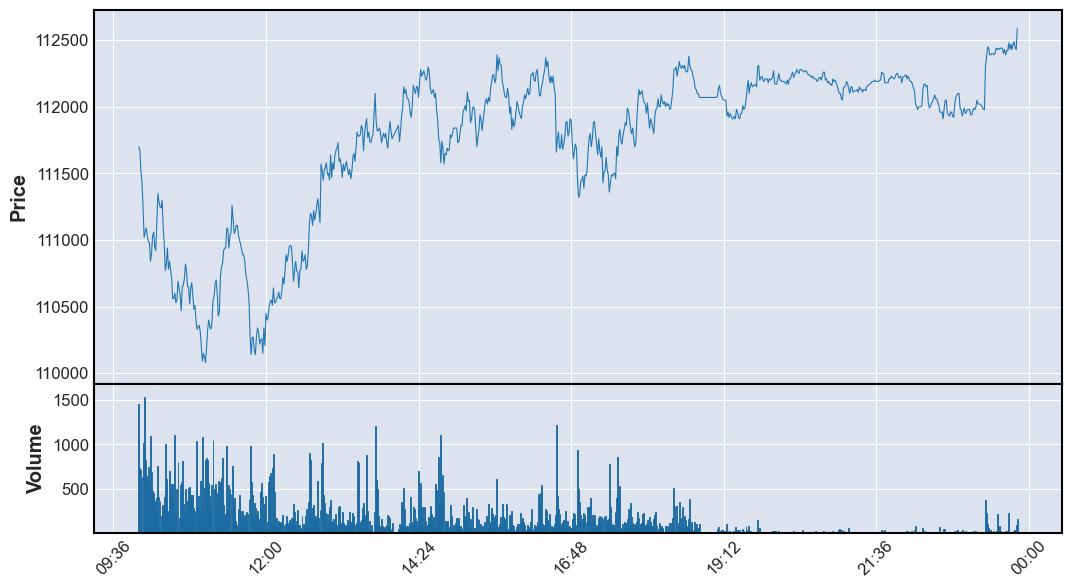

In [6]:
mpf.plot(one_minute_bar.dropna(),
         type='line',
         volume=True,
         figratio=(18,10),figscale=1.3,show_nontrading=True)

Function to create volume bars.

In [60]:
def get_volume_bars(df,trades_per_min=None):
    temp_ = df.copy().reset_index()

    temp_['volume_cumsum'] = temp_['volume'].cumsum()

    if trades_per_min  == None:
        trades_per_min  = temp_['volume'].sum()/(60*14) # 14 hours * 60 minutes

    by_vol = temp_.groupby(temp_['volume_cumsum'].div(trades_per_min ).round().astype(int))

    vol_bars = pd.concat([by_vol['datetime'].last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
    
    return vol_bars

vol_bars = get_volume_bars(trades)

Let's plot volume bars.

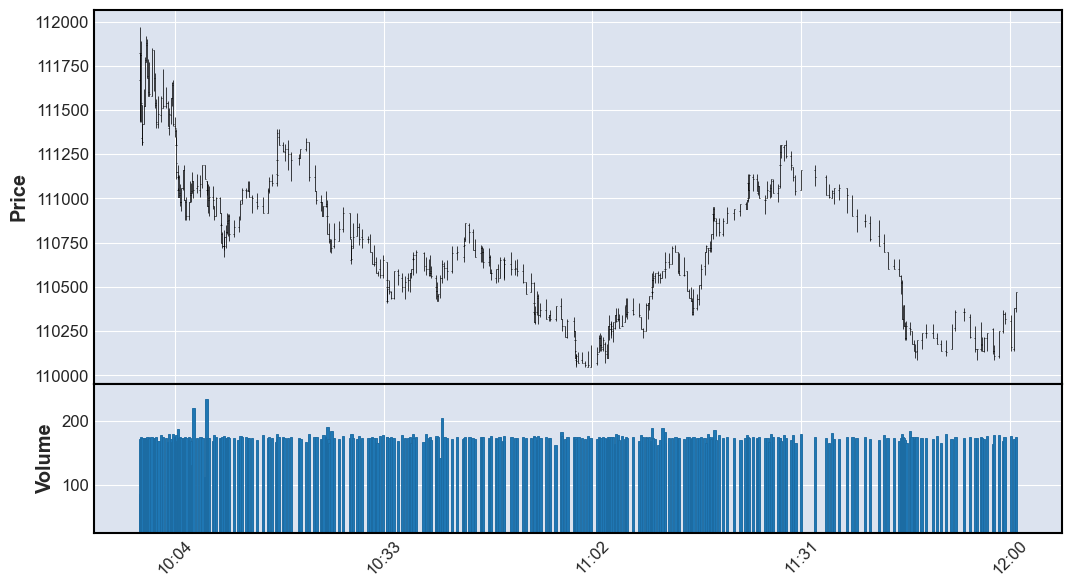

In [61]:
mpf.plot(vol_bars.set_index('timestamp')['2022-08-19 10:00':'2022-08-19 11:00'],
         # type='line',
         volume=True,
         figratio=(18,10),figscale=1.3,show_nontrading=True)

Function to create dollar bars.

In [70]:
def get_dollar_bars(df,value_per_min=None):

    temp_ = df.copy().reset_index()

    value_per_min = temp_['volume'].mul(temp_['price']).sum()/(60*14)

    temp_['cumul_val'] = temp_['volume'].mul(temp_['price']).cumsum()

    by_value = temp_.groupby(temp_['cumul_val'].div(value_per_min).round().astype(int))

    dollar_bars = pd.concat([by_value['datetime'].last().to_frame('timestamp'), get_bar_stats(by_value)], axis=1)

    return dollar_bars
dollar_bars = get_dollar_bars(trades)

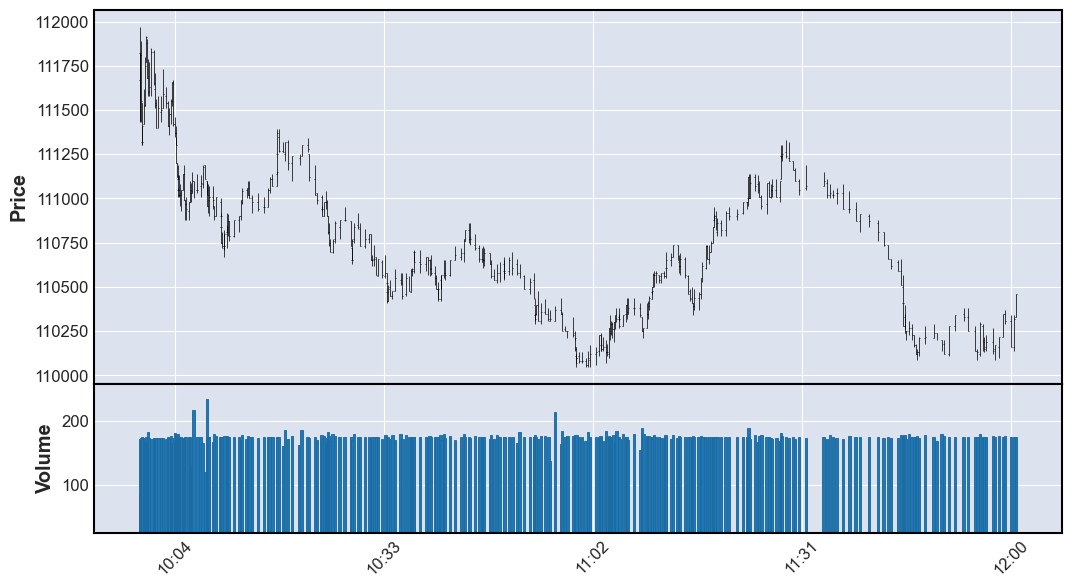

In [71]:
mpf.plot(dollar_bars.set_index('timestamp')['2022-08-19 10:00':'2022-08-19 12:00'],
         # type='line',
         volume=True,
         figratio=(18,10),figscale=1.3,show_nontrading=True)